# Stochastic Gradient Descent on a Twitter Feed

### Michael Frasco

### Preliminaries

In [1]:
sc

In [2]:
import json
import string
import math
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
from operator import itemgetter
import requests

In [3]:
tweets = sc.textFile("s3n://stat-37601/tweets.json").map(json.loads)

### Generating Features

##### Methodology

Each tweet is represented as a high dimensional vector of binary digits (i.e. ones and zeros). Each binary digit represents the presence or absence of a specific token in that tweet. On a simplistic view, the tokens in the tweet are just the words (separated by spaces) in the tweet.

However, I underwent a more complicated token-generating process. First, I converted the entire string of text to lower case so that the words "Happy" and "happy" were not two different features. I extracted any emoticons present in the tweet by checking for the presence of a manually written list of empticons. I  removed all punctuation characters, since I  do not believe they have meaningful sentiment information. I binded the words "not", "very", and "really" with whatever word follows, to prevent including the token "happy" when the tweet says "I am not happy". Furthermore, to generate a higher order representation of human speech, I also included two-grams of the most common adjectives. Lastly, I removed common words that contain no sentiment information, known as stop words.

In order to discover the most common adjectives to use as two-grams, I ran created a vocabulary dictionary and looked at the most common words. Then I re-ran the dictionary with a new function that added stop words. I used a similar process to find the most common stopwords.

In [4]:
# Input: a string.
# Output: a list of emoticons present in the string
emoticons = [':)', ':D', ':(', ';)', ':-)', ':P', '=)',
             '(:', ';-)', ':/', 'XD', '=D', ':o', '=]',
             'D:', ';D', ':]', ':-(', '=/', '=(']
def getSmileys(text, emoticons):
    emoticonList = []
    for smiley in emoticons:
        if smiley in text:
            emoticonList.append(smiley)
    return emoticonList

In [5]:
# Input: a list of tokens
# Output: a list of the two-grams
twoGramWords = ['good','love','work','great','feel','wish','sorry',
                'bad','fun','nice','hate','happy','sad','better',
                'never','awesome','ok','feeling','friends','sick',
                'cool','makes','amazing','terrible','stupid','dumb',
                'worst','best','sucks','angry','mad','hate','boss',
                'girl','boy','mom','dad','friend','brother','sister',
                'wife','husband']
def getTwoGrams(tokens, twoGramWords):
    twoGramList = []
    for i in range(len(tokens)):
        if tokens[i] in twoGramWords:
            if i != len(tokens)-1:
                twoGramList.append(" ".join((tokens[i], tokens[i+1])))
            if i != 0:
                twoGramList.append(" ".join((tokens[i-1], tokens[i])))
    return twoGramList

In [6]:
# Input: a list of tokens
# Ouput: a list of tokens without stop words
stopWords = ['a','about','across','after','along','around','all','also',
             'among','an','and','any','are','as','at','be','because',
             'below','between','by','been','but','by','can','cannot',
             'could','did','do','does','during','either','else','ever',
             'every','except','for','from','get','got','had','has','have',
             'how','however','if','in','into','is','it','its','just',
             'let','like','likely','may','might','must','my','near',
             'of','off','often','on','only','onto','or','other','our',
             'own','over','per','rather','said','say','says','should',
             'since','so','some','than','that','the','their','them',
             'then','there','these','they','this','through','tis',
             'to','too','twas','until','upon','was','we','were','what',
             'when','where','which','while','who','whom','will','with',
             'would','yet']
#'i','you','im','me','up','out','now','no',
#'dont','your','cant','going','back','am','still','u','oh',
#'well','amp','last','more','thats','didnt','ive','youre']
def removeStopWords(tokens, stopWords):
    copyTokens = []
    for word in tokens:
        if word not in stopWords:
            copyTokens.append(word)
    return copyTokens

In [7]:
# input: a list of tokens
# output: a new list of tokens with "not" and "happy" combined as "not_happy"
def addAdverb(tokens):
    copyTokens = []
    notIndicator = False
    for i in range(len(tokens)-1):
        if notIndicator:
            notIndicator = False
            continue
        if tokens[i] == "not" or tokens[i] == "really" or tokens[i] == "very":
            notWord = tokens[i] + "_" + tokens[i+1]
            copyTokens.append(notWord)
            notIndicator = True
        else:
            copyTokens.append(tokens[i])
    return copyTokens

In [8]:
# Input: a dictionary with the id, label, and text
# Output: a tuple with the id, the label, and the tokens
def tokenize(tweet, emoticons, twoGramWords, stopWords):
    idNum = tweet['id']
    label = tweet['label']
    text = tweet['text']
    decoded = text.encode("ascii", "ignore")
    lowerCase = decoded.lower()
    emoticonList = getSmileys(lowerCase, emoticons)
    noPunc = lowerCase.translate(string.maketrans("",""), string.punctuation)
    tokens = noPunc.split(" ")
    tokens = [t for t in tokens if t != '']
    tokens = addAdverb(tokens)
    twoGrams = getTwoGrams(tokens, twoGramWords)
    allTokens = tokens + twoGrams + emoticonList
    allTokens = removeStopWords(allTokens, stopWords)
    tokenSet = set(allTokens)
    tokenSet.add("ConstantTerm")
    return (idNum, label, tokenSet)

In [9]:
tokenizedTweets = tweets.map(lambda x: tokenize(x, emoticons, twoGramWords, stopWords))

In [10]:
tweetList = tokenizedTweets.collect()

##### Implementation

After generating a list of tokens according to the process above, I did not actually create a vector of ones and zeros for each tweet. Instead, I used dictionaries to store token information for each tweet and coefficient information on each token. I read through each tweet and placed any new tokens into my "vocab" dictionary as keys. The value for each key is a dictionary with a key for the coefficient and a key for the number of times that token occurs across all tweets. This way, when I want to sum up the token coefficients for a given tweets, I need only look up each token's coefficient in the dictionary, which takes constant time due to the nature of python's dictionaries. I also removed words from my vocabulary that occurred infrequently to reduce the size of the dictionary. These words are being looked up so rarely that it is not useful to keep them.

I experimented with various frequency thresholds and compared the results. I found that removing tokens that occur less than 25 times achieved the best balance between accuracy and run time. Noticably, if I made the threshold too high, the accuracy went down significantly. This suggests that there are a number of infrequent but highly predictive words in the vocabulary.

In [11]:
# Input: a tweet
# Output: possible new entry in vocabulary dictionary
def buildVocab(tweet, vocabDict):
    tokens = tweet[2]
    tokens = list(tokens)
    for word in tokens:
        if word not in vocabDict:
            vocabDict[word] = {'coef':0, 'count':1}
        else:
            vocabDict[word]['count'] += 1

In [12]:
vocabDict = {}
for tweet in tweetList:
    buildVocab(tweet, vocabDict)

In [13]:
# Remove low-frequency words
for word in vocabDict.keys():
    if vocabDict[word]['count'] < 25:
        del vocabDict[word]

### Stochastic Gradient Descent 

In the functions below, I implement stochastic gradient descent. The general idea will be to process each tweet one at a time. If the tweet is labelled, I will compare the predicted value with the true label, updating the coefficients of the tokens in the tweet accordingly. If the tweet is unlabelled, I will make a prediction in my prediction dictionary.

In [14]:
# input: a list of tokens and the vocabulary dictionary
# output: the sum of the coefficients for those tokens
def getCoefSum(tokens, vocabDict):
    rv = 0
    for word in tokens:
        if word in vocabDict:
            rv += vocabDict[word]['coef']
    return rv

In [15]:
def sigmoid(x):
    return 1 / (1 + math.exp(-x))

In [16]:
# input: id number, prediction
# output: updated entry in prediction dictionary
def updatePredDict(idNum, prediction, predDict):
    if idNum not in predDict:
        predDict[idNum] = prediction
    else:
        predDict[idNum] = prediction

In [17]:
def isError(pred, label):
    if (pred < 0.5) & (label == u'1'):
        return 1
    elif (pred > 0.5) & (label == u'0'):
        return 1
    else:
        return 0

In [18]:
# This function processes each tweet using the functions above
def processTweet(tweet, vocabDict, predDict, stepSize, numErrors, labelled, reg):
    idNum = tweet[0]
    label = tweet[1]
    tokens = tweet[2]
    pred = sigmoid(getCoefSum(tokens, vocabDict))
    if label != u'?':
        for word in tokens:
            if word in vocabDict:
                current = vocabDict[word]['coef']
                vocabDict[word]['coef'] += stepSize * ((int(label) - pred) - (reg * current))
        numErrors += isError(pred, label)
        labelled += 1
    else:
        if pred < 0.5:
            prediction = u'0'
        else:
            prediction = u'1'
        updatePredDict(idNum, prediction, predDict)
    return numErrors, labelled

In [19]:
# input: list of all tweets, vocabulary dictionary for each token,
        # number of passes to make over the tweets, the type of step size,
        # the constant term for the step size, and the regularization constant
# output: the prediction dictionary and the error rate
def runSGD(tweetList, vocabDict, numPasses, step, constant, reg):
    predDict = {}
    numErrors = 0
    labelled = 0
    errorRate = []
    counter = 0
    for i in range(numPasses):
        for tweet in tweetList:
            counter += 1
            if step == "inverse":
                stepSize = float(constant) / counter
            elif step == "sqrt":
                stepSize = float(constant) / math.sqrt(counter)
            else:
                stepSize = step
            numErrors, labelled = processTweet(tweet, vocabDict, predDict, stepSize, numErrors, labelled, reg)
            if labelled % 1000 == 0:
                errorRate.append(float(numErrors) / labelled)
    return (predDict, errorRate)

In [20]:
# Useful for visualizing results
def makePlot(errorRate1, errorRate2, errorRate3, title, leg1, leg2, leg3):
    plt.plot(errorRate1)
    plt.plot(errorRate2)
    plt.plot(errorRate3)
    plt.xlabel("Number of tweets processed (1000s)")
    plt.ylabel("Error Rate")
    plt.title(title)
    red_patch = mpatches.Patch(color='red', label=leg1)
    blue_patch = mpatches.Patch(color='blue', label=leg2)
    green_patch = mpatches.Patch(color='green', label=leg3)
    plt.legend(handles=[red_patch, blue_patch, green_patch])
    plt.show()

##### Results 

I am fairly satisfied with the results (less than 23% error rate) of my algorithm. I am surprised that the error rate doesn't decrease more when we pass through the tweets a second and third time. However, it must be that the coefficients are so fine tuned after the first pass that the error rate cannot change much. I passed through the tweets a maximum of four times, but the error rate doesn't change much after the second pass.

I actually was not surprised that the constant step size gave me results slightly better than the square root step size. I feel like the inverse of square root step size decreases to zero too quickly. For such a large vocabulary, the step size decreases too fast.

I found that regularizing with values greater than 0.1 gave very poor results. I compared the values of the parameters with different levels of regularization to confirm that high regularization leads to low parameter values. I found that a lower regularization parameter of 0.01 was the most appropriate for the square root step rate, while a smaller value worked better for the constant step rate.

I tried various values of the constant term for the different step sizes. I found that a large constant term (e.g. 7) worked best for the inverse and square root step sizes. However, it did not make a huge difference. For the constant step size, I found that small values like 0.001 worked well.

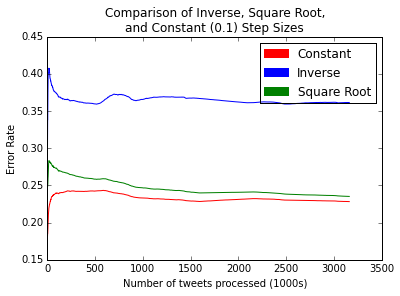

In [21]:
predDict1, errorRate1 = runSGD(tweetList, vocabDict, 3, "inverse", 7, 0.01)
predDict2, errorRate2 = runSGD(tweetList, vocabDict, 3, "sqrt", 7, 0.01)
predDict3, errorRate3 = runSGD(tweetList, vocabDict, 3, 0.001, 1, 0.001)
makePlot(errorRate1, errorRate2, errorRate3,
         "Comparison of Inverse, Square Root,\nand Constant (0.1) Step Sizes",
         "Constant", "Inverse", "Square Root")

In [22]:
print errorRate1[3000]
print errorRate2[3000]
print errorRate3[3000]

0.361651447661
0.23635783222
0.229094283593


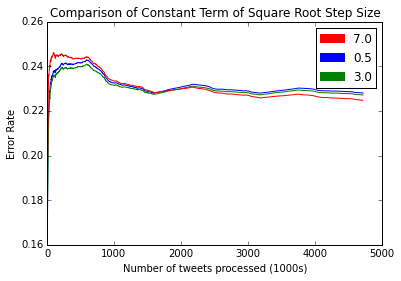

In [23]:
#predDict1, errorRate1 = runSGD(tweetList, vocabDict, 3, "sqrt", 0.1, 0.01)
#predDict2, errorRate2 = runSGD(tweetList, vocabDict, 3, "sqrt", 1, 0.01)
#predDict3, errorRate3 = runSGD(tweetList, vocabDict, 3, "sqrt", 10, 0.01)
#makePlot(errorRate1, errorRate2, errorRate3,
#         "Comparison of Constant Term of Square Root Step Size",
#         '10.0', '0.1', '1.0')

In [24]:
print errorRate1[4000]
print errorRate2[4000]
print errorRate3[4000]

0.229593568062
0.228684502357
0.226633767674


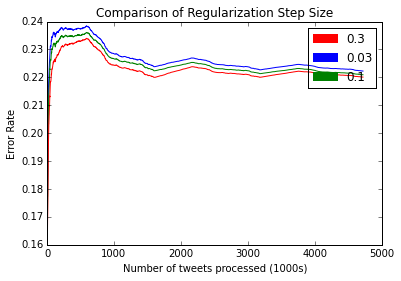

In [25]:
#predDict1, errorRate1 = runSGD(tweetList, vocabDict, 3, "sqrt", 7, 0.001)
#predDict2, errorRate2 = runSGD(tweetList, vocabDict, 3, "sqrt", 7, 0.01)
#predDict3, errorRate3 = runSGD(tweetList, vocabDict, 3, "sqrt", 7, 0.1)
#makePlot(errorRate1, errorRate2, errorRate3,
#         "Comparison of Regularization Step Size",
#         '0.001', '0.3', '0.01')

In [26]:
print errorRate1[4000]
print errorRate2[4000]
print errorRate3[4000]

0.22393373995
0.222511782645
0.221580260604


In [27]:
import requests
packed_results = "\n".join(["{0} {1}".format(key, value.strip()) for key, value in predDict3.items()])
print requests.post("http://lsda.cs.uchicago.edu:5000", files={"results": packed_results}).json()

{u'of': 157638, u'correct': 121997}
